In [24]:
# 1. Import libraries
import ast 
import pandas as pd
from datasets import load_dataset 
import matplotlib.pyplot as plt 
import seaborn as sns 

# 2. Load a dataset
ds = load_dataset("lukebarousse/data_jobs")  

df_copy = ds['train'].to_pandas()  

df = df_copy.copy()  


# 3. Data cleaning
df['job_posted_date'] = pd.to_datetime(df.job_posted_date)  

df['job_skills'] = df['job_skills'].apply(
    lambda skills: ast.literal_eval(skills) if pd.notna(skills) else []
)

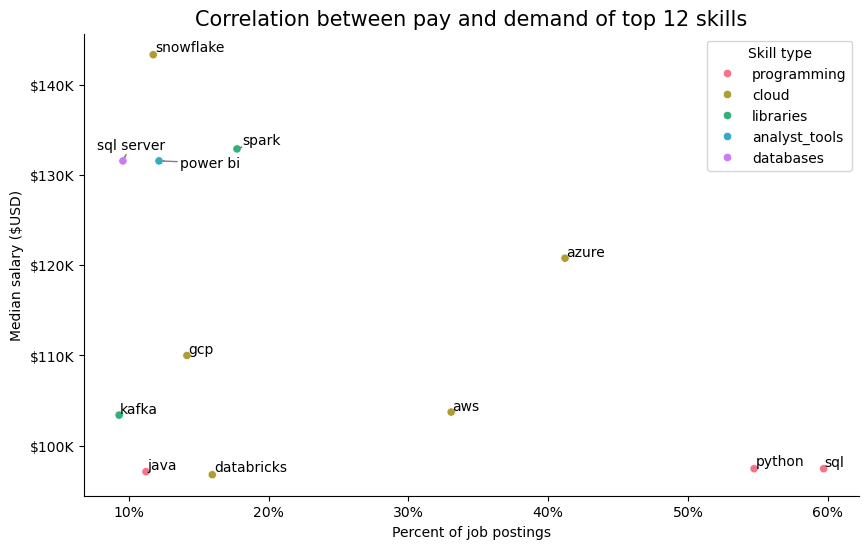

In [25]:
# 1. Filter dataset for a specific country and job title
df_uk = df[
    (df['job_country'] == df['job_country'].value_counts().index[2]) & 
    (df['job_title_short'] == df['job_title_short'].value_counts().index[1])
].copy()
# Select the third most common country and the second most common job title

# 2. Get total number of job postings for this title
numb = df_uk['job_title_short'].value_counts().iloc[0]

# 3. Explode the job_skills list into separate rows
df_exp = df_uk.explode('job_skills')

# 4. Group by skill to calculate median salary and demand count
df_group = df_exp.groupby('job_skills').agg(
    median_salary=('salary_year_avg', 'median'),
    demand_count=('job_skills', 'count')
)
df_group.reset_index(inplace=True)

# 5. Sort skills by demand and calculate percentage of postings
df_group.sort_values(by='demand_count', ascending=False, inplace=True)
df_group['pct'] = df_group['demand_count'] / numb * 100
df_group.set_index('job_skills', inplace=True)

# 6. Keep top 12 skills
df_final = df_group.head(12)

# 7. Process skill types from 'job_type_skills' column
df_skills = df_uk['job_type_skills'].copy()
df_skills.drop_duplicates(inplace=True)
df_skills.dropna(inplace=True)

skills = {}
for row in df_skills:
    row_skill = ast.literal_eval(row)
    for key, value in row_skill.items():
        if key in skills:
            skills[key] += value
        else:
            skills[key] = value

s_skills = pd.Series(skills)
skill = s_skills.explode()

skill_df = skill.reset_index()
skill_df.columns = ['type', 'job_skills']
skill_df.drop_duplicates(inplace=True)

# 8. Merge skill type information with top 12 skills
df_merge = df_final.merge(skill_df, how='left', on='job_skills')
df_merge.set_index('job_skills', inplace=True)

# 9. Plot scatter of pay vs demand
from adjustText import adjust_text
plt.figure(figsize=(10, 6))
colors = sns.color_palette("husl", 5)

sns.scatterplot(
    data=df_merge, 
    x='pct', 
    y='median_salary', 
    hue='type', 
    palette=colors
)

# 10. Add skill names as text labels
texts = []
for i, txt in enumerate(df_merge.index):
    texts.append(plt.text(df_merge['pct'].iloc[i], df_merge['median_salary'].iloc[i], txt))

# 11. Format axes
ax = plt.gca()
from matplotlib.ticker import FuncFormatter, PercentFormatter
ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f'${int(x/1000)}K'))
ax.xaxis.set_major_formatter(PercentFormatter(decimals=0))

# 12. Adjust text to avoid overlapping labels
adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray'))

# 13. Final plot styling
sns.despine()
plt.legend().set_title('Skill type')
plt.ylabel('Median salary ($USD)')
plt.xlabel('Percent of job postings')
plt.title('Correlation between pay and demand of top 12 skills', fontsize=15)
plt.show()